# 一、上個月賣最好的手機品牌

從 PowerBI 結果可以知道幾個資訊，

1. 總銷售量最高的是，Samsung

2. 平均銷量最高的是，Apple

3. 綜合評價最高的是，Xiaomi

4. 平均售價最高的是，Sony

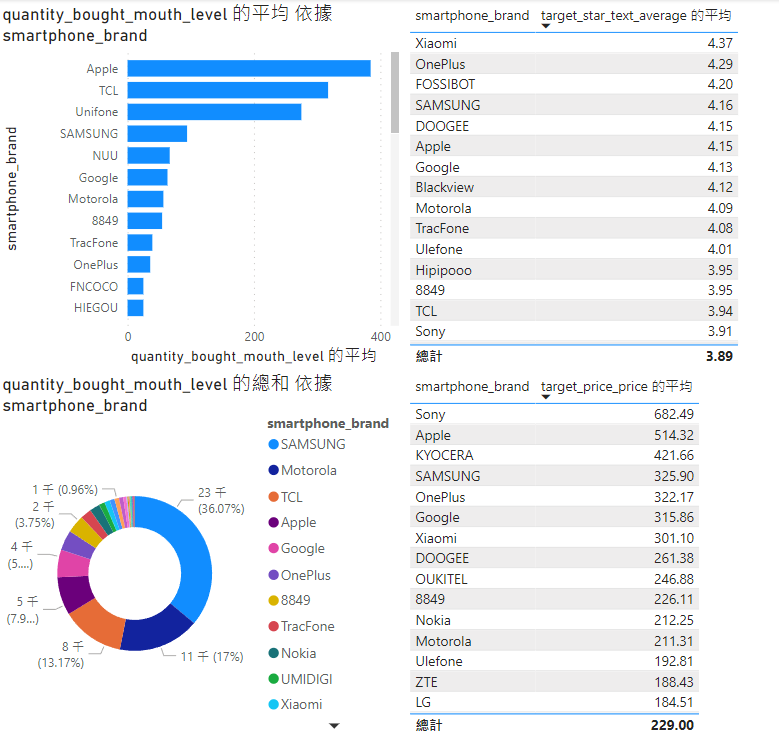

## 重構問題

回到問題本身，哪個品牌才是賣最好的手機？

有關於賣最好這個概念，我們可以區分為，總銷量最高、單一產品銷售能力，兩個概念。總銷量無須進一步驗證，三星賣最多，但有關於單一產品競爭力，蘋果是否顯著優於其他品牌，還有待驗證。

是故，以下將進行各品牌的單因子變異數分析 (Anova)。


In [4]:
import re, os, pandas
from pingouin import pairwise_gameshowell
import pingouin as pg
import scipy.stats as stats

df = pandas.read_csv("database_clean.csv")
df.head(3)

,smartphone_brand,target_title,target_url,target_price,target_star_text,quantity_bought_mouth,quantity_bought_mouth_level,target_price_price,target_price_unit,target_star_text_average,target_star_text_max
0,Motorola,Motorola Moto G Stylus | 2022 | 2 天電池 | 解鎖 | 專...,https://www.amazon.com/-/zh_TW/Motorola-Moto-S...,US$128.00,4.3 顆星，最高 5 顆星,過去一個月有3000個以上顧客購買,3000,128.0,US,4.3,5.0
1,Motorola,Motorola Moto G Power 5G | 2023 | 解鎖 | 專為美國 6/...,https://www.amazon.com/-/zh_TW/Motorola-Power-...,NaN,4.3 顆星，最高 5 顆星,過去一個月有1000個以上顧客購買,1000,NaN,NaN,4.3,5.0
2,Motorola,Moto G Play 2023 3 天電池解鎖 美國製造 3/32GB 16MP 相機 海軍藍,https://www.amazon.com/-/zh_TW/Moto-Play-2023-...,NaN,4.0 顆星，最高 5 顆星,過去一個月有3000個以上顧客購買,3000,NaN,NaN,4.0,5.0


In [9]:
df["smartphone_brand"].unique()

array(['Motorola', 'Google', 'TCL', 'TracFone', 'Apple', 'BLU',
       'Total by Verizon', 'OnePlus', 'Nokia', 'Xiaomi', 'SAMSUNG',
       'UMIDIGI', 'DOOGEE', 'NUU', 'Ulefone', 'Blackview', 'Sony',
       'Alcatel', 'OUKITEL', 'fuxinya', 'Xgody', 'ZTE', 'KYOCERA', 'LG',
       'FOSSIBOT', 'FNCOCO', 'BDWJW', 'Sefwon', 'USHINING', 'HIEGOU',
       'Hipipooo', 'Hilitand', 'Cuifati', '8849', 'PUSOKEI', 'GOWENIC',
       'Heayzoki', 'ASHATA', 'Jectse', 'Unifone'], dtype=object)

## 變異數檢定結果

1. levene > 0.05 變異數不同質，

接下來將採用 不假設變異數同質的 Welch's_anova 檢定。

In [10]:
import re, os, pandas
import pingouin as pg
import scipy.stats as stats

df = pandas.read_csv("database_clean.csv")

# 執行 Shapiro-Wilk_test、(常態性檢定)
def Shapiro_Wilk_test(df) :
    p_value = stats.shapiro(df).pvalue
    return p_value

# 執行變異數同質性檢定
def levene_test(df_1, df_2) :
    p_value = stats.levene(df_1, df_2).pvalue
    return p_value

# 進行變異數同質性檢定
levene_test_p = stats.levene(df[df["smartphone_brand"] == "Apple"]["quantity_bought_mouth_level"], df[df["smartphone_brand"] == "TCL"]["quantity_bought_mouth_level"], df[df["smartphone_brand"] == "Unifone"]["quantity_bought_mouth_level"], center='mean').pvalue
if levene_test_p > 0.05 : 
    print("變異數不同質")
else : 
    print("變異數同質")


變異數不同質


##  Welch's_anova 檢定 結果

F 檢定結果，< 0.05，平均數有顯著差異。

In [11]:
# f_oneway 檢定
data = df[df["smartphone_brand"].isin(["Apple", "TCL", "Unifone"])].copy()
anova_result = pg.welch_anova(data= data , dv= "quantity_bought_mouth_level", between= "smartphone_brand")
anova_result


,Source,ddof1,ddof2,F,p-unc,np2
0,smartphone_brand,2,3.067311,0.040699,0.960627,0.003038


## Games-Howell檢定 (事後檢定)
組間差異來源於，Apple、TCL ; TCL、Unifone，故得證，Apple 銷量平均顯著優於其餘兩者。從而得到，Apple 具有最高的單一產品競爭力。

In [12]:
from pingouin import pairwise_gameshowell

posthoc_result = pairwise_gameshowell(data= data, dv= "quantity_bought_mouth_level", between= "smartphone_brand")

posthoc_result

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Apple,TCL,384.615385,317.307692,67.307692,278.674218,0.241528,14.293970,0.968424,0.102194
1,Apple,Unifone,384.615385,275.000000,109.615385,348.756243,0.314304,4.959391,0.947565,0.111257
2,TCL,Unifone,317.307692,275.000000,42.307692,239.329067,0.176776,1.279239,0.983145,0.099555


# 二、如何預測產品銷量

## 此處以 機器學習中的 多項式迴歸分析舉例

一個產品的評價，很有可能與產品的銷量相關。是故，此處以產品評價作為自變數，用以預測產品銷量。

In [23]:
import pandas

## 導入視覺化套件
import matplotlib.pyplot as plt

## 導入Sklearn套件
## 導入將數據集拆成訓練集與測試集的套件
from sklearn.model_selection import train_test_split

## 導入迴歸模型套件
from sklearn.linear_model import LinearRegression

## 導入多項式套件，建構多項式迴歸模型所需的套件
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

df = pandas.read_csv("database_clean.csv")

## 去除遺漏值
df = df[["target_star_text_average", "quantity_bought_mouth_level"]]
df = df.dropna()

## 將數據集拆成訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(df["target_star_text_average"].values.reshape(-1, 1), df["quantity_bought_mouth_level"].values, test_size = 0.3, random_state = 0)

## 使用訓練集資料來訓練(擬和)迴歸模型
regressor = make_pipeline(PolynomialFeatures(2), LinearRegression())
regressor.fit(X_train, y_train)

## 迴歸模型的準確度
score = regressor.score(X_test, y_test)
print('Score: ', score)

## 拿訓練好的迴歸模型預測測試集資料的目標值(依變數)
y_pred = regressor.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error

# 計算 MAE
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

# 計算 MSE
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)


Score:  0.002150692278450106
MAE: 65.53061633355912
MSE: 33854.90695024039


## 預測能力展現
Score:  0.002150692278450106

MAE: 65.53061633355912

MSE: 33854.90695024039

這個預測能力只能會其爛無比來形容。讓我們看看出現了什麼問題。

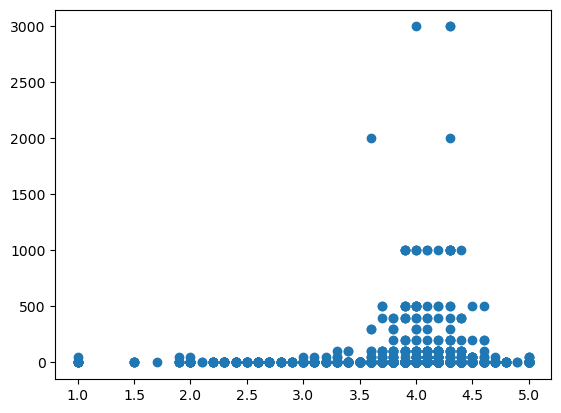

In [21]:
## 視覺化 數據集
plt.scatter(df["target_star_text_average"].values,  df["quantity_bought_mouth_level"].values)
plt.show()

## 可以發現，圖形中，評價與銷量似乎與銷量沒有正相關、負相關的跡象。但從數值 3.5 開始，銷量開始明顯上升。